In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import utility as psu
import scipy.integrate as integ
from scipy.optimize import curve_fit
from scipy import stats
import time
from matplotlib.colors import LogNorm
from numpy.random import randn
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import os
import process_abalone_utility as pau
import process_utility as prsu

/data/abalone/ABALONE_RampingUp/2021_10_11_T0954_ABALONE_24kV_SiPM2_32V_LED300V.dat Number of events 596096.0
Total events number: 596096
event n. 0 time to process: 0.02
event n. 100000 time to process: 22.29
event n. 200000 time to process: 44.57
event n. 300000 time to process: 66.86
event n. 400000 time to process: 89.16
event n. 500000 time to process: 111.37


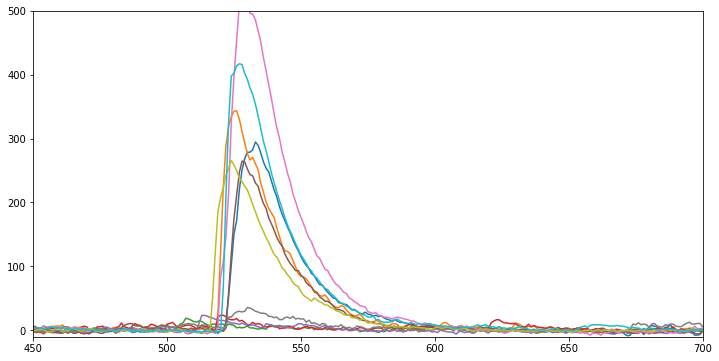

In [2]:
file_LED = '/data/abalone/ABALONE_RampingUp/2021_10_11_T0954_ABALONE_24kV_SiPM2_32V_LED300V.dat'
avolt = 24
dataLED = pau.process_abalone_data(filename=file_LED,nn=0,nplot=10,volts=avolt,sipmv=32,ledv='3')

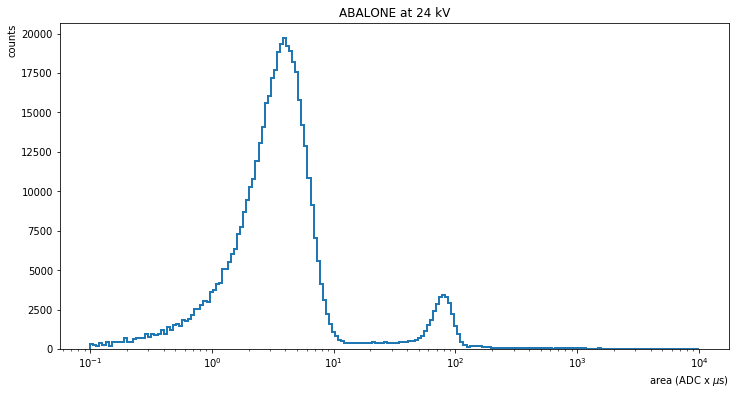

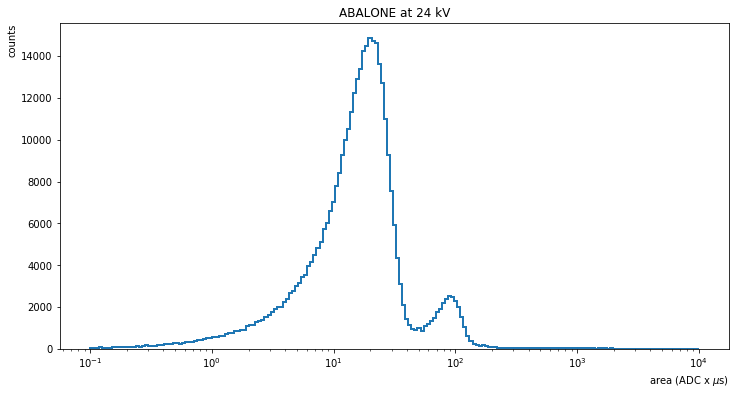

<Figure size 864x432 with 0 Axes>

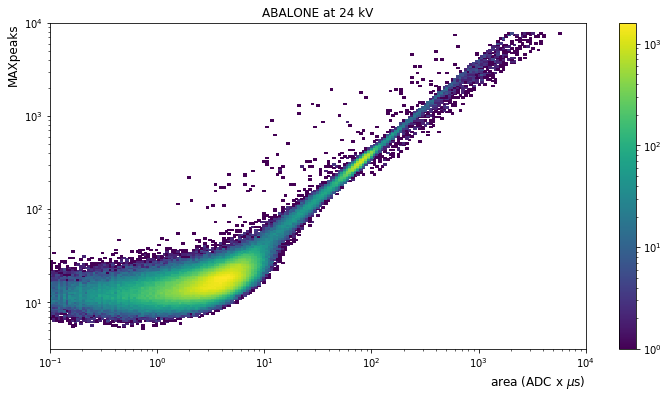

<Figure size 864x432 with 0 Axes>

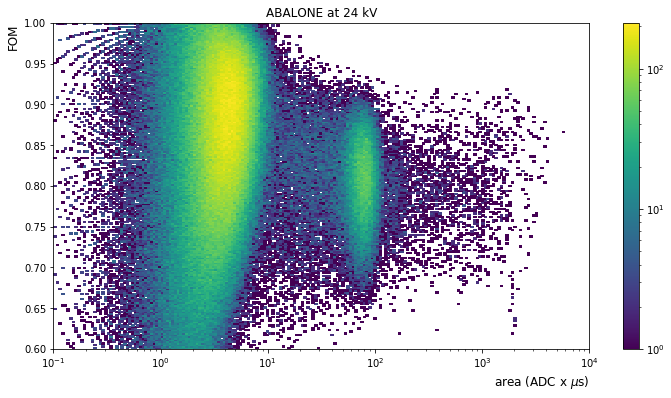

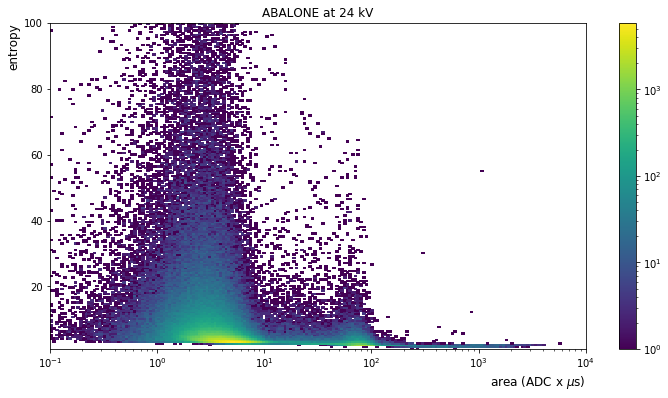

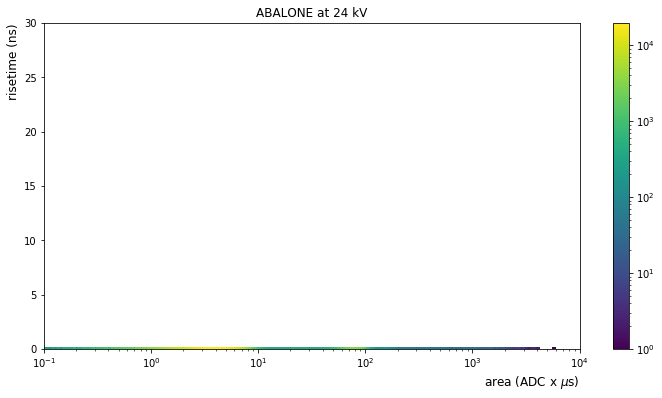

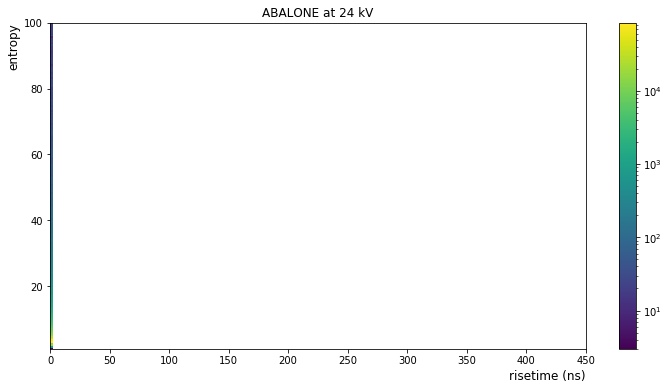

<Figure size 864x432 with 0 Axes>

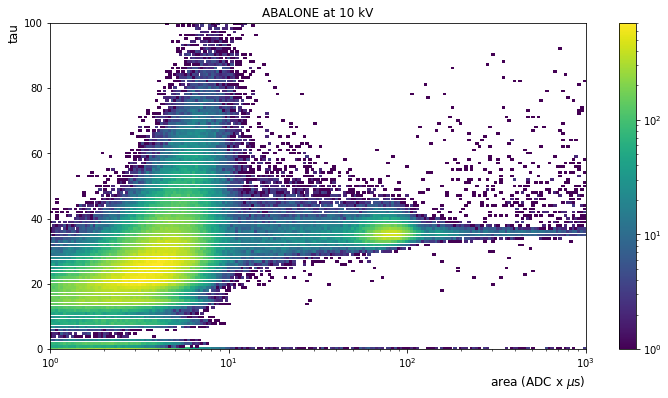

In [3]:
pau.plot_data(data=dataLED,fvolt=avolt,low=-1, high=4,low_max=0.5,high_max=4,low_en=1, high_en=100,
              low_fom=0.6,high_fom=1,high_rt=30)

In [4]:
def select_data_new(data,filename,entr_cut=20,max_cut=20,pos_cut=(100,900),tau_cut=(10,80), events=10,
                save = False, volts = 15, sipmv = 30, ledv = '3p0' ):
    wfs = psu.read_file(filename)
    
    # cut on max
    wfs_cut_max = wfs[data['peak_max']<max_cut]
    try: psu.plot_waveforms( wfs_cut_max, events = events )
    except: pass
    print('Events rejected by max',len(wfs_cut_max),'->',len(wfs_cut_max)/len(data)*100,'%')
    print()
    # cut on max position
    wfs_cut_pos = wfs[(data['max_pos']>pos_cut[1]) | (data['max_pos']<pos_cut[0])]
    try: psu.plot_waveforms( wfs_cut_pos, events = events )
    except: pass
    print('Events rejected by max position',len(wfs_cut_pos),'->',len(wfs_cut_pos)/len(data)*100,'%')
    print()
    # cut on tau
    wfs_cut_tau = wfs[(data['tau']>tau_cut[1]) | (data['tau']<tau_cut[0])]
    try: psu.plot_waveforms( wfs_cut_tau, events = events )
    except: pass
    print('Events rejected by tau',len(wfs_cut_tau),'->',len(wfs_cut_tau)/len(data)*100,'%')
    print()
    # selection
    mask1 = (data['peak_max']>max_cut)
    mask2 = (data['max_pos']<pos_cut[1]) & (data['max_pos']>pos_cut[0])
    mask3 = (data['tau']<tau_cut[1]) & (data['tau']>tau_cut[0])
    mask = mask1 & mask2 & mask3
    wfs_sel = wfs[mask]
    data_sel = data[mask]
    try: psu.plot_waveforms( wfs_sel, events = events )
    except: pass
    if save: data_sel.to_hdf(f'processed_data/data_ABALONE_{volts}kV_SiPM2_{sipmv}V_LED_{ledv}V.h5', key='df', mode='w')
    print('Events selected ',len(data_sel),'->',len(data_sel)/len(data)*100,'%')
    return data_sel, wfs_sel

/data/abalone/ABALONE_RampingUp/2021_10_11_T0954_ABALONE_24kV_SiPM2_32V_LED300V.dat Number of events 596096.0
n. events 515997 waveform samples 1024
Events rejected by max 515997 -> 86.56273486149881 %

n. events 537711 waveform samples 1024
Events rejected by max position 537711 -> 90.20543670818122 %

n. events 507757 waveform samples 1024
Events rejected by tau 507757 -> 85.18040718273566 %

n. events 27016 waveform samples 1024
Events selected  27016 -> 4.532155894352587 %


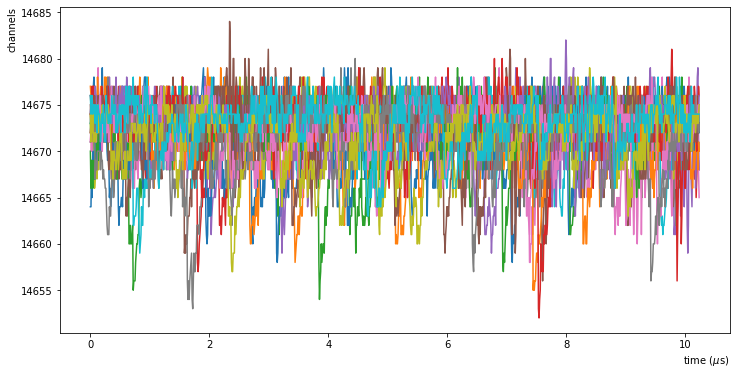

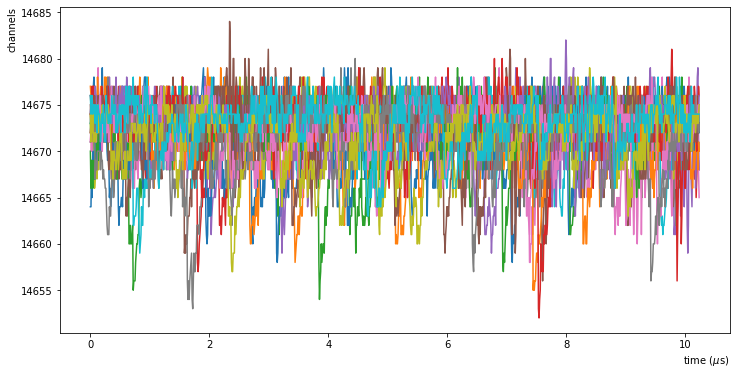

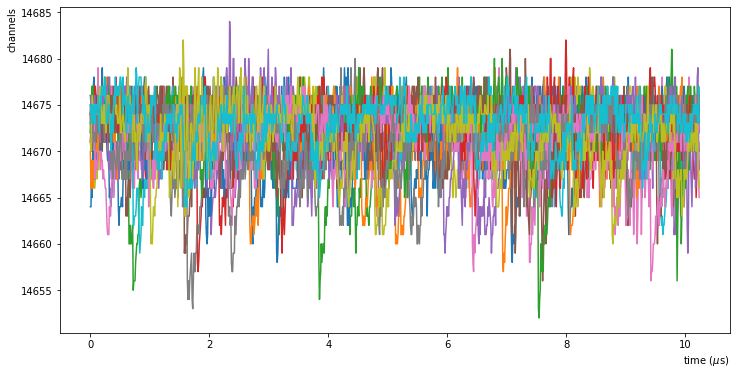

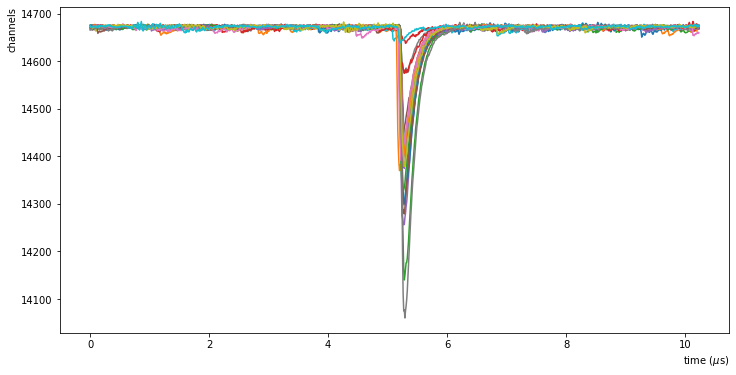

In [5]:
new_data, new_wf = select_data_new(dataLED,filename=file_LED,max_cut=25,pos_cut=(510,540),tau_cut=(32,38),events=20,
                                   save=0, volts=avolt,sipmv=32,ledv='3')

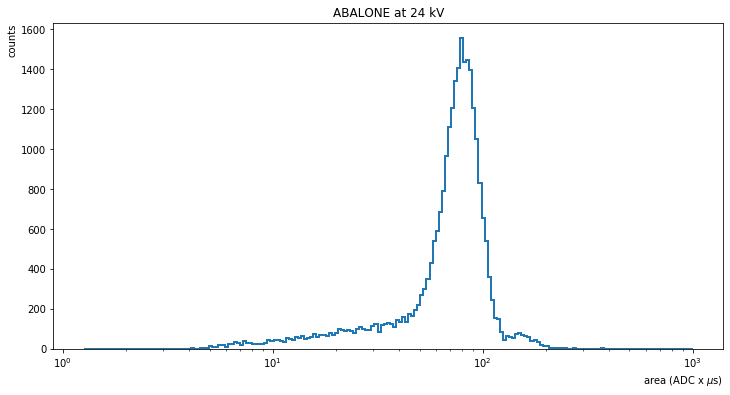

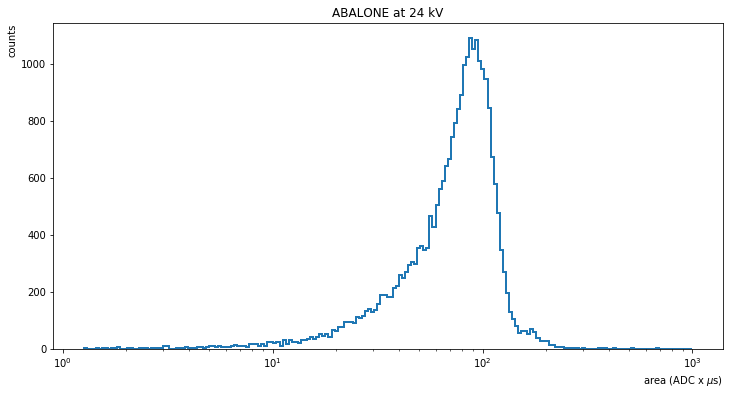

<Figure size 864x432 with 0 Axes>

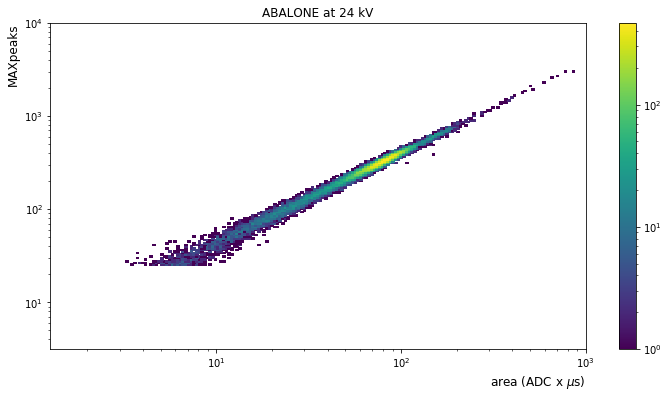

<Figure size 864x432 with 0 Axes>

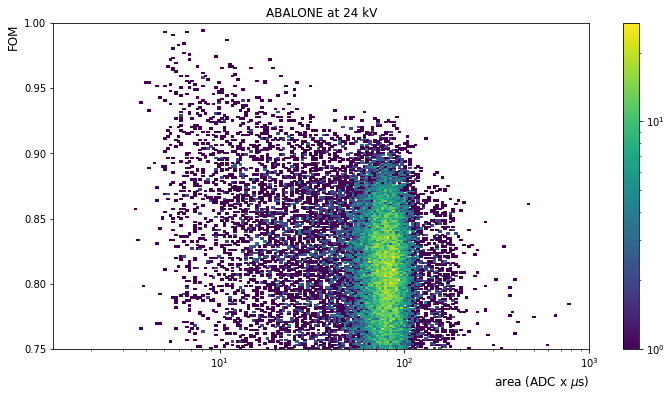

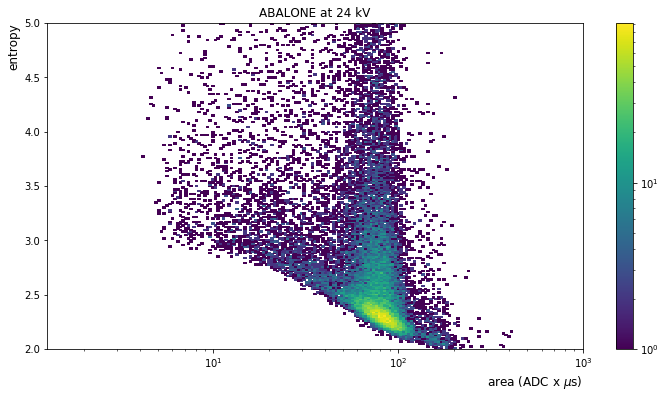

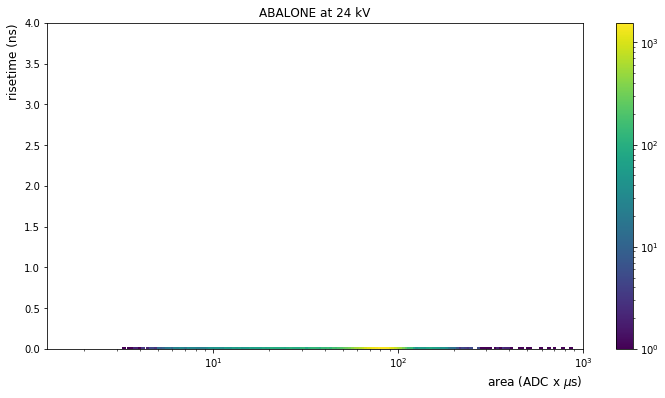

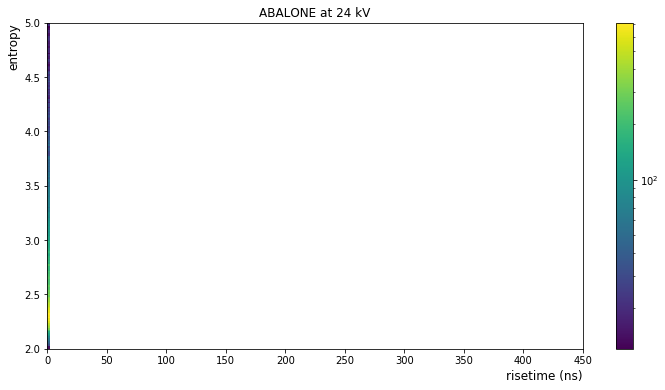

<Figure size 864x432 with 0 Axes>

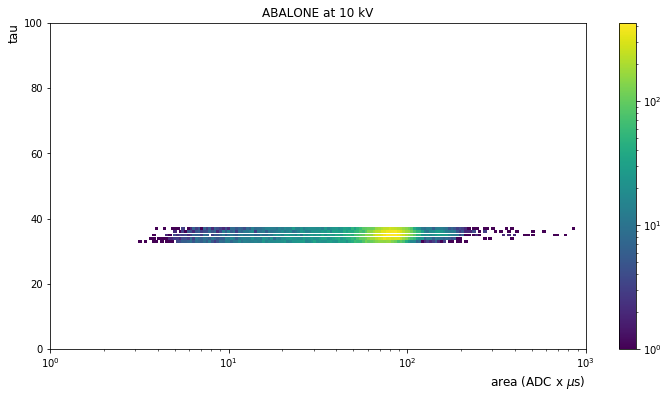

In [6]:
pau.plot_data(data=new_data,fvolt=avolt,low=0.1, high=3,low_max=0.5,high_max=4,low_en=2, high_en=5,
          low_fom=0.75,high_fom=1)

n. events 1201 waveform samples 1024


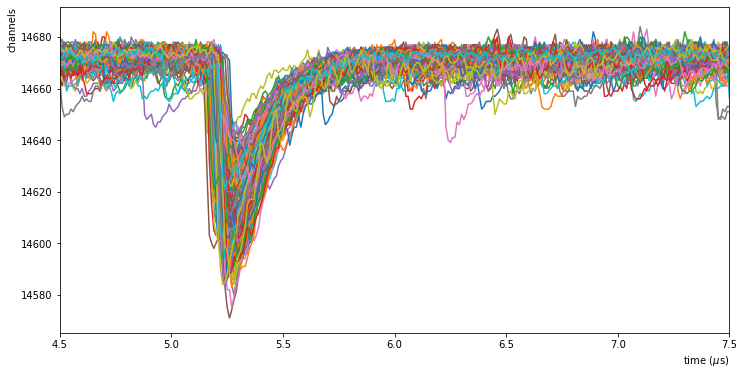

In [7]:
wf2 = new_wf[(new_data['area']>10)&(new_data['area']<20)]
psu.plot_waveforms( wf2,events=150,tlim=(4.5,7.5))

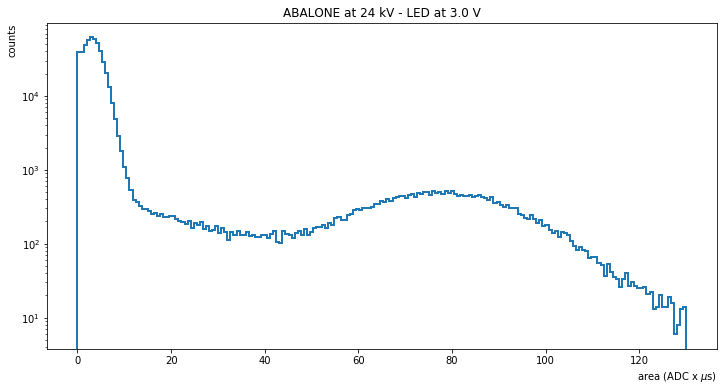

In [8]:
pau.plot_pe_spectrum(dataLED['area'], volts=avolt, low=0, high=130, bins=200, ledv=3)
plt.yscale('log')

In [11]:
import scipy
def gauss(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2 / (2.*sigma**2))
def landau(x,a,loc,scale):
    return 1.6*a*np.exp(-( (x-loc)/scale + np.exp(-(x-loc)/scale) )/2)
#def expgauss(x,a,tau,x0):
#    return a * 1/2 * np.exp((1+2*tau*x0-2*tau*x)/(2*tau**2)) * scipy.special.erfc((1/tau+x0-x)/np.sqrt(2))
def expgauss(x,a,mu,sigma,tau):
    return a/2 * np.exp((sigma**2-2*x*tau)/(2*tau**2))*(1-scipy.special.erf((sigma**2+tau*(mu-x))/(np.sqrt(2)*sigma*tau) ))
def spe_spectrum(x,a1,mu1,sigma1,a2,mu2,sigma2,tau):
    return gauss(x,a1,mu1,sigma1) + expgauss(x,a2,mu2,sigma2,tau)#landau(x,a2,loc,scale)

def fit_spe_spectrum(area, bins = 200, volts = 10, ledv = 3, low = 0, high = 100, sig2=8, save = False):
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space)
    plt.figure(figsize=(8,4.5))
    a1 = plt.hist(area,bins=area_space,histtype='step',lw=2,density=False)
    #SPE guess
    #idx1, idx2 = np.where(t>fit_range[0])[0][0], np.where(t>fit_range[1])[0][0]
    imax = np.argmax(h)
    mu, hmax = t[imax], h[imax]
    idx = np.where(h>hmax/2) # fwhm 
    ilo, ihi = idx[0][0], idx[0][-1]
    sig = (t[ihi]-t[ilo]) / 2.355
    #BS guess
    imax = np.argmax(h)
    mu0, hmax0 = t[imax], h[imax]
    idx = np.where(h[:]>hmax/2) 
    ilo, ihi = idx[0][0], idx[0][-1]
    sig0 = (t[ihi]-t[ilo]) / 2.355
    guess = (hmax, mu, sig, 100, 10, 5,5)
    #guess = (hmax, mu, sig, hmax0, mu0, sig0)
    #bounds = ([hmax*0.9, mu-sig, 0,0, 0, 0],
    #          [1.1*hmax, mu+sig, 2*sig, 1000, 500, 50])
    
    #fit
    popt, pcov = curve_fit(spe_spectrum, t[1:], h, p0 = guess)#, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    print(popt)
    plt.plot(t, spe_spectrum(t, *popt), label = 'spectrum fit')
    gauss_spe = lambda x : gauss(x, *popt[:3])
    expgauss_int = lambda x : expgauss(x, *popt[3:])
    #spe_int = lambda x : spe_spectrum(x, *popt)
    nspe, spe_er = integ.quad(gauss_spe,0,t[-1])
    print('nspe',nspe)
    nbs, bs_er = integ.quad(expgauss_int,0,t[-1])
    print('nbs',nbs)
    #ntot, tot_er  = integ.quad(spe_int,0,t[-1])
    plt.plot(t, gauss(t, *popt[:3]),label=f'SPE at {popt[1]:.2f} $\pm$ {popt[2]:.2f} ADC x $\mu$s')
    plt.plot(t, expgauss(t, *popt[3:]),label=f'{nbs/(nspe+nbs)*100:.1f}% Non-Returning')
    #plt.plot(t, spe_spectrum(t, *guess), label = 'guess')
    #plt.title(f'ABALONE at {volts} kV - LED at {ledv:.1f} V')
    plt.xlabel('area (ADC x $\mu$s)',ha='right',x=1,fontsize=12)
    plt.ylabel('counts',ha='right',y=1,fontsize=12)
    plt.tick_params(axis='x',labelsize=12)
    plt.tick_params(axis='y',labelsize=12)
    plt.legend(fontsize=12)
    if save: plt.savefig('plots/SPEfit.png',dpi=800)
    #return popt[1], popt[2], nspe, nbs

[258.89628728  79.08128107  14.38918685  81.95731644   6.05382266
   1.95981855  59.51422024]
nspe 9337.955942658093
nbs 4013.325714567824


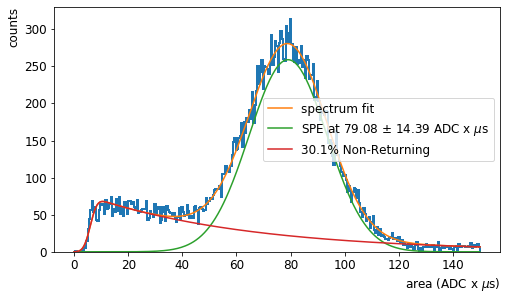

In [12]:
fit_spe_spectrum(new_data['area'], volts = 24, low = 0, high = 150, bins = 300)

# fit con gauss + expgauss

In [ ]:
#def spe_spectrum(x,a1,mu1,sigma1):#,a3,mu2,sigma2):#,a2,loc,scale):
#    return gauss(x,a1,mu1,sigma1)# + gauss(x,a3,mu2,sigma2)#+ landau(x,a2,loc,scale)
def spe_spectrum(x,a1,mu1,sigma1,a2,tau,x0):
    return gauss(x,a1,mu1,sigma1)+ expgauss(x,a2,tau,x0)

def fit_spe_spectrum(area, bins = 200, volts = 10, ledv = 3, low = 0, high = 100, spe_div = 40, sig2=8, save = False):
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space)
    plt.figure(figsize=(8,4.5))
    tc = (t[:-1] + t[1:])/2.
    a1 = plt.hist(area,bins=area_space,histtype='step',lw=2,density=False)
    #SPE guess
    #idx1, idx2 = np.where(t>fit_range[0])[0][0], np.where(t>fit_range[1])[0][0]
    idx1 = np.where(t>spe_div)[0][0]
    imax = np.argmax(h[idx1:])+idx1
    mu, hmax = t[imax], h[imax]
    idx = np.where(h[idx1:]>hmax/2) # fwhm 
    ilo, ihi = idx[0][0], idx[0][-1]
    sig = (t[ihi]-t[ilo]) / 2.355
    #BS guess
    #imax = np.argmax(h[:idx1])
    #mu0, hmax0 = t[imax], h[imax]
    #idx = np.where(h[:idx1]>hmax/2) 
    #ilo, ihi = idx[0][0], idx[0][-1]
    #sig0 = (t[ihi]-t[ilo]) / 2.355
    #guess = (hmax, mu, sig, hmax0, mu0, sig0, hmax/2, 20, 5)
    guess = (hmax, mu, sig, 300, 25, 4)#, hmax/2, 25, 5)
    #bounds = ([hmax*0.9, mu-sig, 0,hmax0*0.9, mu0-sig0, 0, 0, mu0, 0],
    #          [1.1*hmax, mu+sig, 2*sig, 1.1*hmax0, mu+sig0, 2*sig0, hmax, mu, sig2])
    bounds = ([hmax*0.9, mu-sig, 0, 0, 0, 1],
              [1.1*hmax, mu+sig, 2*sig, 350, 50, 5])
    #fit 
    print(t[idx1+1], h[idx1])
    popt, pcov = curve_fit(spe_spectrum, tc[idx1:], h[idx1:], p0 = guess, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    print(popt)
    plt.plot(t, spe_spectrum(t, *popt), label = 'spectrum fit')
    gauss_spe = lambda x : gauss(x, *popt[:3])
    #gauss_bs = lambda x : gauss(x, *popt[3:])
    gauss_bs = lambda x : expgauss(x, *popt[3:])
    #landau_int = lambda x : landau(x, *popt[3:6])
    spe_int = lambda x : spe_spectrum(x, *popt)
    nspe, spe_er = integ.quad(gauss_spe,0,t[-1])
    print('nspe',nspe)
    nbs, bs_er = integ.quad(gauss_bs,0,t[-1])
    print('nbs',nbs)
    #ntot, tot_er  = integ.quad(spe_int,0,t[-1])
    plt.plot(t, gauss(t, *popt[:3]),label=f'SPE at {popt[1]:.2f} $\pm$ {popt[2]:.2f} ADC x $\mu$s')
    #plt.plot(t, landau(t, *popt[3:6]),label=f'SiPM dark counts')
    plt.plot(t, expgauss(t, *popt[3:]),label=f'{nbs/(nspe+nbs)*100:.1f}% Non-Returning')
    plt.plot(t, spe_spectrum(t, *guess), label = 'guess')
    #plt.title(f'ABALONE at {volts} kV - LED at {ledv:.1f} V')
    plt.xlabel('area (ADC x $\mu$s)',ha='right',x=1,fontsize=12)
    plt.ylabel('counts',ha='right',y=1,fontsize=12)
    plt.tick_params(axis='x',labelsize=12)
    plt.tick_params(axis='y',labelsize=12)
    plt.legend(fontsize=12)
    #plt.yscale('log')
    plt.ylim(1,1e3)
    if save: plt.savefig('plots/SPEfit.png',dpi=800)
    return popt[1], popt[2], nspe, nbs

In [ ]:
fit_spe_spectrum(dataLED['area'], volts = 24, low = 0, high = 150, bins = 300,spe_div=20)

# fit con gauss + landau

In [ ]:
def spe_spectrum(x,a1,mu1,sigma1,a2,loc,scale):
    return gauss(x,a1,mu1,sigma1)+ landau(x,a2,loc,scale)

def fit_spe_spectrum(area, bins = 200, volts = 10, ledv = 3, low = 0, high = 100, spe_div = 40,save = False):
    area_space = np.linspace(low,high, bins)
    h, t = np.histogram(area, bins=area_space)
    plt.figure(figsize=(8,4.5))
    tc = (t[:-1] + t[1:])/2.
    a1 = plt.hist(area,bins=area_space,histtype='step',lw=2,density=False)
    #SPE guess
    #idx1, idx2 = np.where(t>fit_range[0])[0][0], np.where(t>fit_range[1])[0][0]
    idx1 = np.where(t>spe_div)[0][0]
    imax = np.argmax(h[idx1:])+idx1
    mu, hmax = t[imax], h[imax]
    idx = np.where(h[idx1:]>hmax/2) # fwhm 
    ilo, ihi = idx[0][0], idx[0][-1]
    sig = (t[ihi]-t[ilo]) / 2.355
    #BS guess
    #imax = np.argmax(h[:idx1])
    #mu0, hmax0 = t[imax], h[imax]
    #idx = np.where(h[:idx1]>hmax/2) 
    #ilo, ihi = idx[0][0], idx[0][-1]
    #sig0 = (t[ihi]-t[ilo]) / 2.355
    #guess = (hmax, mu, sig, hmax0, mu0, sig0, hmax/2, 20, 5)
    guess = (hmax, mu, sig, 150, 18, 10)#, hmax/2, 25, 5)
    #bounds = ([hmax*0.9, mu-sig, 0,hmax0*0.9, mu0-sig0, 0, 0, mu0, 0],
    #          [1.1*hmax, mu+sig, 2*sig, 1.1*hmax0, mu+sig0, 2*sig0, hmax, mu, sig2])
    bounds = ([hmax*0.9, mu-sig, 0, 100, 5, 0],
              [1.1*hmax, mu+sig, 2*sig, 300, 30, 50])
    #fit 
    print(t[idx1+1], h[idx1])
    popt, pcov = curve_fit(spe_spectrum, tc[idx1:], h[idx1:], p0 = guess, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    print(popt)
    plt.plot(t, spe_spectrum(t, *popt), label = 'spectrum fit')
    gauss_spe = lambda x : gauss(x, *popt[:3])
    landau_int = lambda x : landau(x, *popt[3:])
    spe_int = lambda x : spe_spectrum(x, *popt)
    nspe, spe_er = integ.quad(gauss_spe,0,t[-1])
    print('nspe',nspe)
    nbs, bs_er = integ.quad(landau_int,0,t[-1])
    print('nbs',nbs)
    #ntot, tot_er  = integ.quad(spe_int,0,t[-1])
    plt.plot(t, gauss(t, *popt[:3]),label=f'SPE at {popt[1]:.2f} $\pm$ {popt[2]:.2f} ADC x $\mu$s')
    plt.plot(t, landau(t, *popt[3:]),label=f'{nbs/(nspe+nbs)*100:.1f}% Non-Returning')
    plt.plot(t, spe_spectrum(t, *guess), label = 'guess')
    #plt.title(f'ABALONE at {volts} kV - LED at {ledv:.1f} V')
    plt.xlabel('area (ADC x $\mu$s)',ha='right',x=1,fontsize=12)
    plt.ylabel('counts',ha='right',y=1,fontsize=12)
    plt.tick_params(axis='x',labelsize=12)
    plt.tick_params(axis='y',labelsize=12)
    plt.legend(fontsize=12)
    #plt.yscale('log')
    plt.ylim(1,1e3)
    if save: plt.savefig('plots/SPEfit.png',dpi=800)
    return popt[1], popt[2], nspe, nbs

In [ ]:
fit_spe_spectrum(dataLED['area'], volts = 24, low = 0, high = 150, bins = 300, spe_div=20)

In [175]:
#peakint = pau.calculate_integrals( wfs, nn=3, volts=avolt, sipmv = 32, ledv = '3', plot = 1, save = 0,
#                                  dtl=-8, dtr=1, tfit=8)

In [ ]:
#pau.plot_pe_spectrum(peakint, volts=avolt, low=0, high=100, bins=300, ledv=4)

/data/abalone/ABALONE_RampingUp/2021_10_11_T1005_ABALONE_24kV_SiPM2_32V_LED400V.dat Number of events 596617.0
Total events number: 596617
event n. 0 time to process: 0.00
event n. 100000 time to process: 25.64
event n. 200000 time to process: 51.24
event n. 300000 time to process: 76.88
event n. 400000 time to process: 102.64
event n. 500000 time to process: 128.34


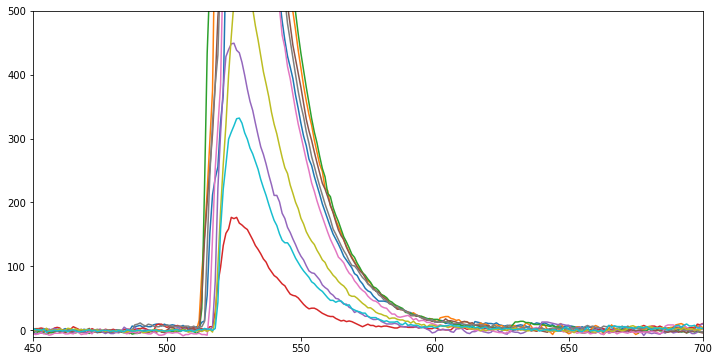

In [208]:
file_LED = '/data/abalone/ABALONE_RampingUp/2021_10_11_T1005_ABALONE_24kV_SiPM2_32V_LED400V.dat'
dataLED = pau.process_abalone_data(filename=file_LED,nn=0,nplot=10,volts=avolt,sipmv=32,ledv='4')

/data/abalone/ABALONE_RampingUp/2021_10_11_T1005_ABALONE_24kV_SiPM2_32V_LED400V.dat Number of events 596617.0
n. events 0 waveform samples 1024
Events rejected by areaup 0 -> 0.0 %

n. events 2496 waveform samples 1024
Events rejected by areadown 2496 -> 0.4183588466302502 %

n. events 0 waveform samples 1024
Events rejected by entropy 0 -> 0.0 %

n. events 0 waveform samples 1024
Events rejected by max 0 -> 0.0 %

n. events 0 waveform samples 1024
Events rejected by risetime 0 -> 0.0 %

n. events 35423 waveform samples 1024
Events rejected by max position 35423 -> 5.937309865458074 %

n. events 0 waveform samples 1024
Events selected  0 -> 0.0 %


<Figure size 864x432 with 0 Axes>

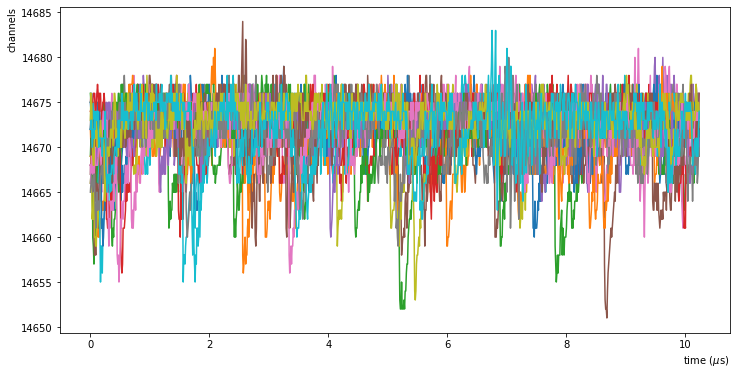

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

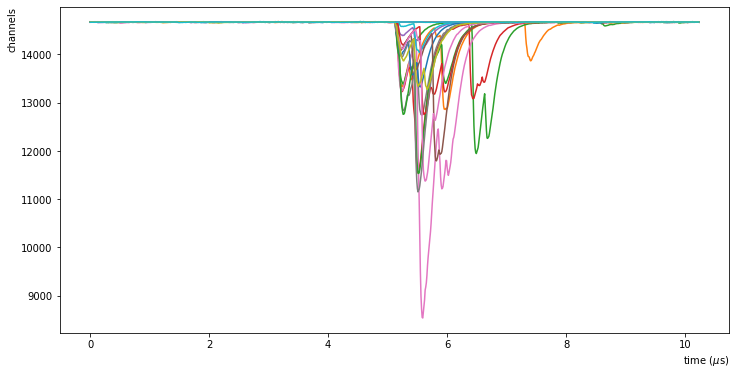

<Figure size 864x432 with 0 Axes>

In [209]:
new_data, new_wf = pau.select_data(dataLED,filename=file_LED,entr_cut=200,max_cut=1,area_cut=(0,1e7),
                                   pos_cut=(500,550),rt_cut=0,events=20, save=1,volts=avolt,sipmv=32,ledv='4')

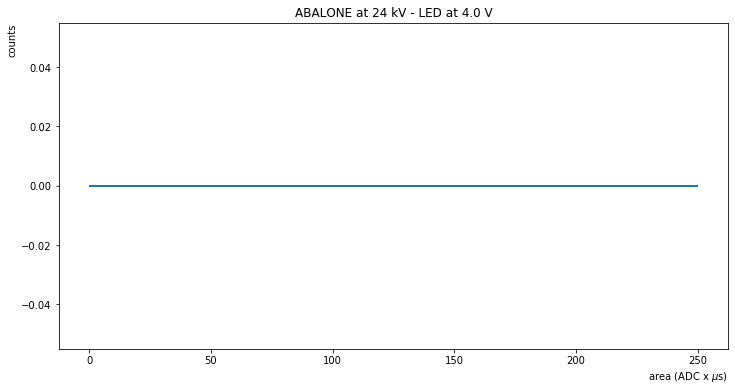

In [210]:
pau.plot_pe_spectrum(new_data['area'], volts=avolt, low=0, high=250, bins=300, ledv=4)